## Méthodes d'optimisation stochastique

## I. Minimisation stochastique d'une fonction déterministe


On s'intéresse au problème $\min f(x) =\max_{i=1\dots m}|a_i^Tx-b_i | = \max_{i=1\dots m} |(Ax-b)_i|.$ 

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne nulle et d'écart type identité.

**Question 1 :** Constuire $A$ et $b$. Proposer le calcul d'un sous-gradient en $x$ de $f$. On pourra utiliser la fonction findmax de Julia. 


In [1]:
import Pkg
using Random , Distributions , LinearAlgebra , JuMP , HiGHS , GLPK , Noise , Plots , Statistics

In [2]:
# Construction des données A  et b
# Insérer votre code
m = 100;
n = 20;
A = randn(m,n);
b = randn(m,1);
# Fin insérer code

# Fonction calculant un sous-gradient en x de f
function subgrad(A,b,x) 
    # Insérer votre code
    #savoir les indice qui ont le max
    L = A*x - b;
    L = L[:]
    x_max,i_max = findmax(abs.(L));
    #fin savoir les indices qui ont le max
    l = (A[i_max,:]'*x)[:][1] - b[i_max];

    sub = sign(l)*A[i_max,:];
    # Fin insérer code
    return sub
end

subgrad (generic function with 1 method)

**Question 2 :** Ce problème peut se reformuler comme un problème de programmation linéaire : $$(\mathcal{P}_{lp})\quad \left\{ \begin{array}{c} \min_{(x,R)\in \mathbb{R}^n\times \mathbb{R}} h(x,R)=R\\
s.c. \quad-R*e\leq A*x-b\leq R*e\end{array}\right.$$ avec $e=[1,\cdots,1]^T\in \mathbb{R}^m$. Résoudre le problème $(\mathcal{P}_{lp})$ en utilisant le solveur "GLPK" de la librairie JuMP. Plus d'informations sont disponibles ici :  http://www.juliaopt.org/JuMP.jl/latest/quickstart/

In [3]:
#using Pkg
#Pkg.add("JuMP"); 
#Pkg.add("GLPK")

e = ones(m,1);
# Définition du modèle
# Insérer votre code
model = Model(GLPK.Optimizer)
# Fin insérer code

# Définition des variables d'optimisation
# Insérer votre code
@variable(model,x[1:n])
@variable(model,R)
# Fin insérer code

# Définition de la fonctionnelle à minimiser
#Insérer votre code
@objective(model,Min,R)
# Fin insérer code

# Définition des contraintes
# Insérer votre code
#@constraint(model,[i = 1:m],-R*e[i] <= ((A[i,:]'*x)[:][1] - b[i]) <= R*e[i])
@constraint(model,  0.0 .<= (A * x - b) + R*e)
@constraint(model, (A * x - b) - R*e .<= 0.0)
# Fin insérer code
        
# Résolution        
# Insérer votre code
JuMP.optimize!(model)
# Fin insérer code
        
# Résultats à optimalité                
# Insérer votre code
Rstar = JuMP.value.(R);
xstar = JuMP.value.(x);
fstar = objective_value(model)
# Fin insérer code
println("The function value at the solution is: ",Rstar, " or ",findmax(abs.(A*xstar-b)))


The function value at the solution is: 1.5541351919091309 or (1.554135191909133, CartesianIndex(86, 1))


**Question 3 :** Résoudre le problème en utilisant un algorithme de sous-gradient. Dans un premier temps vous utiliserez un sous-gradient exact (Question 1), puis vous introduirez un bruit artificiel qui suit une distribution normale de moyenne nulle et d'écart-type $3 e-1$.

**Question 4 :** Vous afficherez les courbes de convergence de $f_{best}^k-f_{star}$, avec $f_{star}$ obtenue à la Question 1. Donnez la valeur minimale de $f_{best}^k-f_{star}$.

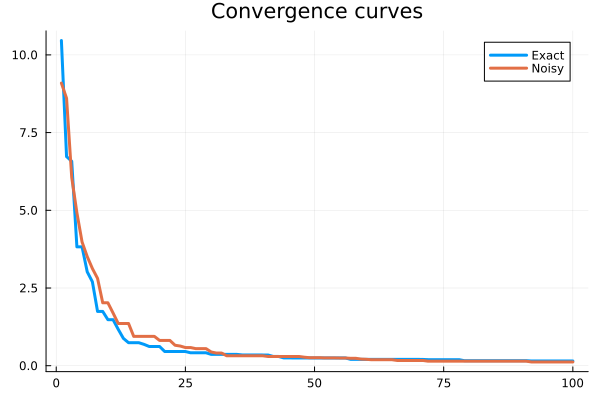

In [4]:


#Initialisation
x = zeros(n,1);
i = 0;
fbest =1e10; # $f_{best}^0$: cas du sous-gradient exact
fbestp=1e10; # $f_{best}^0$: cas du sous-gradient bruité
histo =[];# Suite des itérés f_{best}^k-f_{star} pour le cas du sous-gradient exact
histop=[];# Suite des itérés f_{best}^k-f_{star}, pour le cas du sous-gradient bruité

#Niveau de bruit
noise_lvl=.3;

# Resolution 
# Insérer votre code
#algorithme de sous_gradient exact 
k = 0;
nbmax = 100;
while (k<nbmax)
    alpha = 1/(k+1);
    sous_grad = subgrad(A,b,x);
    x = x - (alpha)*sous_grad;
    k = k +1;
    fmax = findmax(abs.(A*x-b));
    if (fbest>first(fmax))
        fbest= first(fmax);
    end
    push!(histo,fbest-first(fstar));
end
##########################################
e = ones(m,1);
#algorithme de sous_gradient bruité
x = zeros(n,1);
k = 0;
while (k<nbmax)
    alpha = 1/(k+1);
    sous_grad = subgrad(A,b,x);
    x = x - (alpha)*add_gauss(sous_grad,noise_lvl);
    k = k +1;
    fmax = findmax(abs.(A*x-b));
    if (fbestp>first(fmax))
        fbestp= first(fmax);
    end
    push!(histop,fbestp - first(fstar));
end
# Fin insérer code
#Affichage des courbes de convergence
iter=1:100;
hf=[histo,histop];
plot(iter,hf,title="Convergence curves",label=["Exact" "Noisy"],lw=3)

## II. Minimisation stochastique d'une fonction stochatique



On s'intéresse au problème
$$\min_x f(x) =\text{E} (\max_{i=1\dots m}|a_i^Tx-b_i |).$$

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne connue $\bar{A}$ et $\bar{b}$ (non nécesairement nulle) et d'écart type identité.

**Question 5 :** Proposer deux fonctions d'évaluation de la fonction $f$ et d'un sous-gradient de $f$ basées sur des échantillons de taille $M$.


In [5]:
# Evaluation de f
function fvals(Abar,bbar,noise,xs,M) 
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon

# Insérer votre code
m, n = size(Abar)

max_values = zeros(M)
for i = 1:M
    A = Abar + noise*randn(m, n);
    b = bbar + noise*randn(m,1);
    fmax = findmax(abs.(A*xs-b));
    max_values[i] = first(fmax);
end

return mean(max_values)
# Fin insérer code

end

# Evaluation d'un sous-gradient
function subgrads(Abar,bbar,noise,xs,M)
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon
    
# Insérer votre code
m, n = size(Abar)
A = Abar + noise*randn(m,n)
b = bbar + noise*randn(m,1)

all_subs = zeros(n,M)
for i = 1:M
   all_subs[:,i] = subgrad(A,b,xs)
end
return mean(all_subs,dims=2)
# Fin insérer code
end


subgrads (generic function with 1 method)

**Question 6 :** Comparer les courbes de convergence du problème déterministe $$ \min_x f(x) = \max_{i=1\dots m}|\text{E} (a_i)^Tx-\text{E} (b_i) |,$$ et du problème stochastique obtenu avec $M=10,100,1000$ échantillons. Donnez la valeur minimale de $f$.

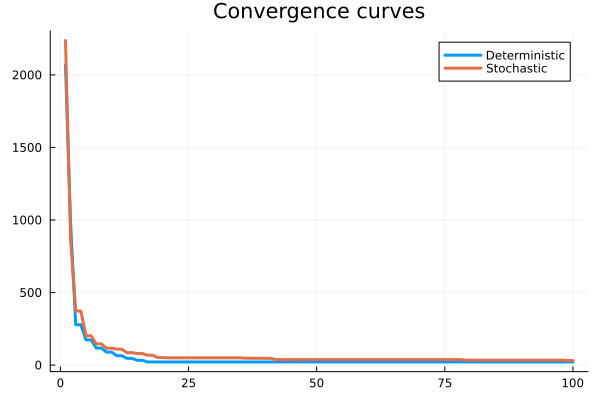

In [6]:
# Données
Abar=10*ones(m,n)+1*randn(m,n);
bbar=10*randn(m,1);

#x_0
xd = zeros(n,1); # problème déterministe
xs = xd; # problème stochastique

# Bruit et echantillon
M  = 200;
noise  = 4;

j = 0;

fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
histod =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution déterministe
histos =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution stochastique

# Insérer votre code
#deterministe 
k = 0;
nbmax = 100;
while (k<nbmax)
    alpha = 1/(k+1);
    sous_grad = subgrad(Abar,bbar,xd);
    xd = xd - (alpha)*sous_grad;
    k = k +1;
    fmax = findmax(abs.(Abar*xd-bbar));
    if (fbestd>first(fmax))
        fbestd= first(fmax);
    end
    push!(histod,fbestd);
end
####################
#stochasitque
k = 0;
nbmax = 100;
while (k<nbmax)
    alpha = 1/(k+1);
    sous_grad_s = subgrads(Abar,bbar,noise,xs,M);
    xs = xs - (alpha)*sous_grad_s;
    k = k +1;
    fmax = fvals(Abar,bbar,noise,xs,M);#findmax(abs.(Abar*xs-bbar));
    #fmax = fvals(Abar,bbar,noise,xs,M);
    if (fbests>first(fmax))
        fbests= first(fmax);
    end
    push!(histos,fbests);
end
#############
# Fin insérer code
#Affichage

iter=1:100;
hf=[histod,histos];
plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)

**Question 7 :** Répéter les expériences et comparer les  meilleurs valeurs de f obtenues ($f_{best}$) aprs un nombre fixé d'itérations. Donnez la valeur minimale de $f_{best}$

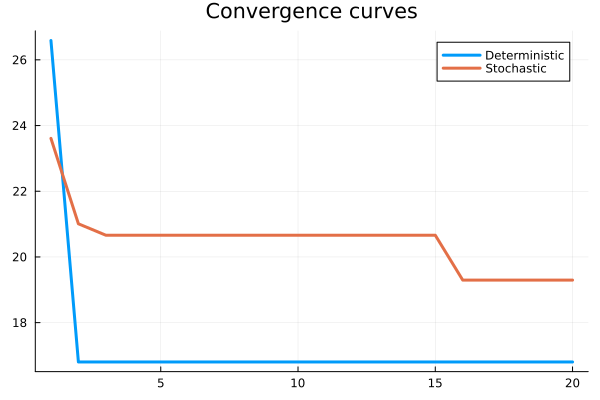

In [54]:
# Données
Abar=10*ones(m,n)+1*randn(m,n);
bbar=10*randn(m,1);

# x_0
xd = zeros(n,1); # résolution déterministe
xs = xd;  # résolution stochastique

# Bruit et echantillon
M  = 200;
noise  = 0.4;

#Nombre d'itérations
niter=100;

j = 0;

fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
fbesttd=[]; # f_{best} pour chaque expériences dans le cas d'une résolution déterministe
fbestts=[]; # f_{best} pour chaque expériences dans le cas d'une résolution stochastique

for nexp=1:20
    # Répétition des expériences    
# Insérer votre code
##################################
##deterministe
    Abar=10*ones(m,n)+1*randn(m,n);
    bbar=10*randn(m,1);
    k = 0;
    nbmax = 100;
    while (k<nbmax)
        alpha = 1/(k+1);
        sous_grad = subgrad(Abar,bbar,xd);
        xd = xd - (alpha)*sous_grad;
        sous_grad_s = subgrads(Abar,bbar,noise,xs,M);
        xs = xs - (alpha)*sous_grad_s;
        k = k +1;
        fmax1 = findmax(abs.(Abar*xd-bbar));
        fmax2 = fvals(Abar,bbar,noise,xs,M);#findmax(abs.(Abar*xs-bbar));
        if (fbestd>first(fmax1))
            fbestd= first(fmax1);
        end
        #Stochastic
        #fmax = fvals(Abar,bbar,noise,xs,M);
        if (fbests>first(fmax2))
            fbests= first(fmax2);
        end
        ###########
    end
    append!(fbesttd,fbestd);
    append!(fbestts,fbests);
# Fin insérer code
# Fin insérer code
end


#Affichage
iter=1:20;
hf=[fbesttd,fbestts];
plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)